# Task

With AI-modelling and Data Science there is plenty of opportunity to improve processes or suggest improved ways of doing things. When doing so it is often very smart and efficient (time is a scarce resource) to create a POC (Proof of Concept) which basically is a small demo checking wether it is worthwile going further with something. It is also something concrete which facilitates discussions, do not underestimate the power of that. 

In this example, you are working in a company that sells houses and they have a "manual" process of setting prices by humans. You as a Data Scientist can make this process better by using Machine Learning. Your task is to create a POC that you will present to your team colleagues and use as a source of discussion of wether or not you should continue with more detailed modelling. 

Two quotes to facilitate your reflection on the value of creating a PoC: 

"*Premature optimization is the root of all evil*". 

"*Fail fast*".


**More specifially, do the following:**
1. A short EDA (Exploratory Data Analysis) of the housing data set.
2. Drop the column `ocean_proximity`, then you only have numeric columns which will simplify your analysis. Remember, this is a POC! 
3. You have missing values in your data (not sure you do but you can assume so). Handle this with `SimpleImputer(strategy="median")`. (Check the fantastic Scikit-learn documentation for details.) Notice, the `SimpleImputer` should only be used for transformation on the validation and test data, not fitting.
4. Split your data into `X` and `y`, and then into train, validation and test sets. 
5. Create one `LinearRegression` model and one `Lasso` model. For the `Lasso` model, use `GridSearchCV` to optimize $\alpha$ values. Choose yourself which $\alpha$ values to evaluate.
Use RMSE as a metric to decide which model to choose. 

6. Which model is best on the validation data? 

7. Evaluate your chosen model on the test set using the root mean squared error (RMSE) as the metric. 
What are your conclusions? Note: to be 100% sure, you should re-fit your chosen model on the combination of train+val data. 

8. Do a short presentation (~ 2-5 min) on your POC that you present to your colleagues (no need to prepare anything particular, just talk from the code). Think of:
- What do you want to highlight/present?
- What is your conclusion?
- What could be the next step? Is the POC convincing enough or is it not worthwile continuing? Do we need to dig deeper into this before taking some decisions?

------------
Bonus question for those who have time and are ambitious: Redo everything above (copy your code) but in step 2, include the column `ocean_proximity` which is a categorical column. 

# Code

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
# Below, set your own path where you have stored the data file if it is not in the /data folder. 
housing = pd.read_csv(r'C:\Users\Michael\Desktop\EC Utbildning som Data Scientist\06_ML\Kunskapskontroll\1\housing.csv')

## EDA

In [4]:
print(housing.describe())

          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.00000

In [5]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [6]:
print(housing.isnull().sum())

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


We can see that there are 207 missing values for total_bedrooms - something that we will fix using the SimpleImputer after we have split our data (in order to avoid potential contamination).

In [7]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


So I was struggling a little bit to comprehend the histograms I built below, so I thought I would take a look at the data and see what it actually looks like. The issues that I can see is that there are many values within the 'housing_median_age' that are set to 52, which is I believe incorrect - it is 52=<, meaning that the data looks unusual. The same can be noted for 'median_house_value' - where a large number of areas have the maximum value here too, set to 500001, but really is 500001=<. 

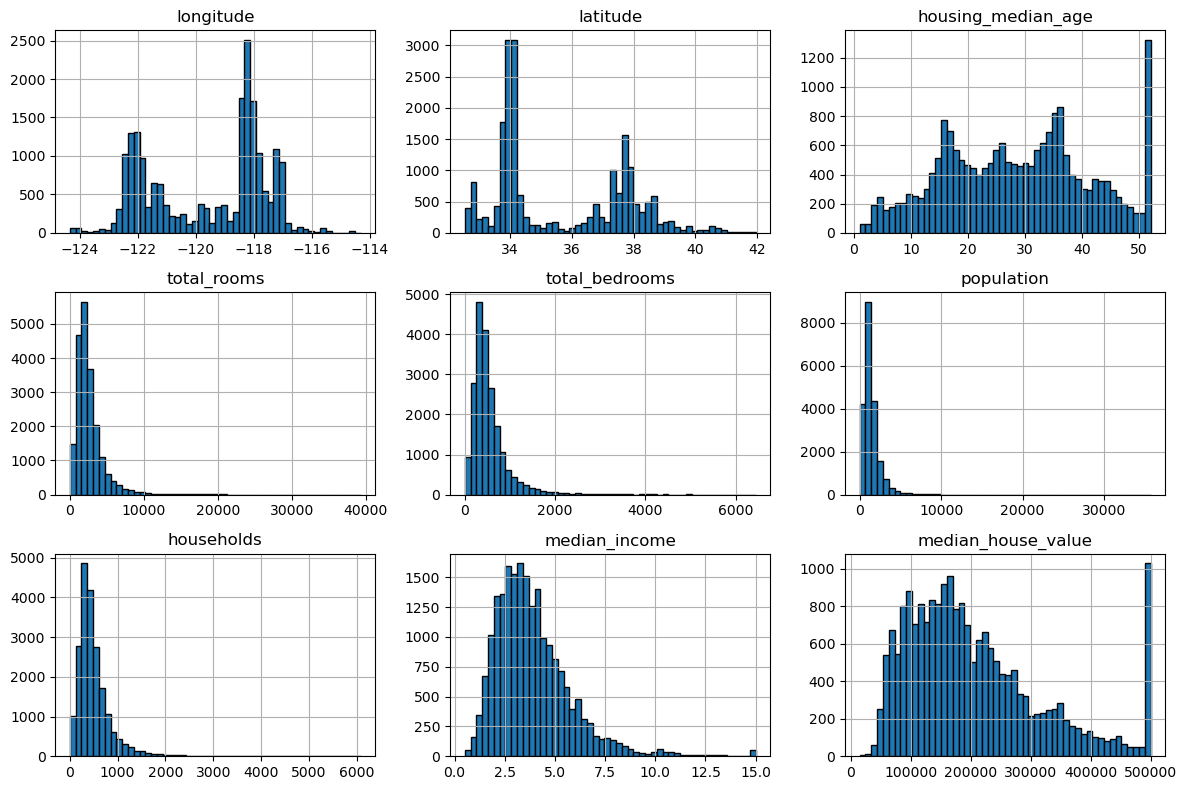

In [8]:
housing.hist(figsize=(12, 8), bins=50, edgecolor='black')
plt.tight_layout()
plt.show()

Histograms showing the distributions of the variables that exist within the data. Here we can see that most are left skewed distributions, with some interesting values occurring in the extreme far ends of the distributions within median_house_value and housing_median_age. We can take a closer look at these cases to judge how we handle them within the model later. 

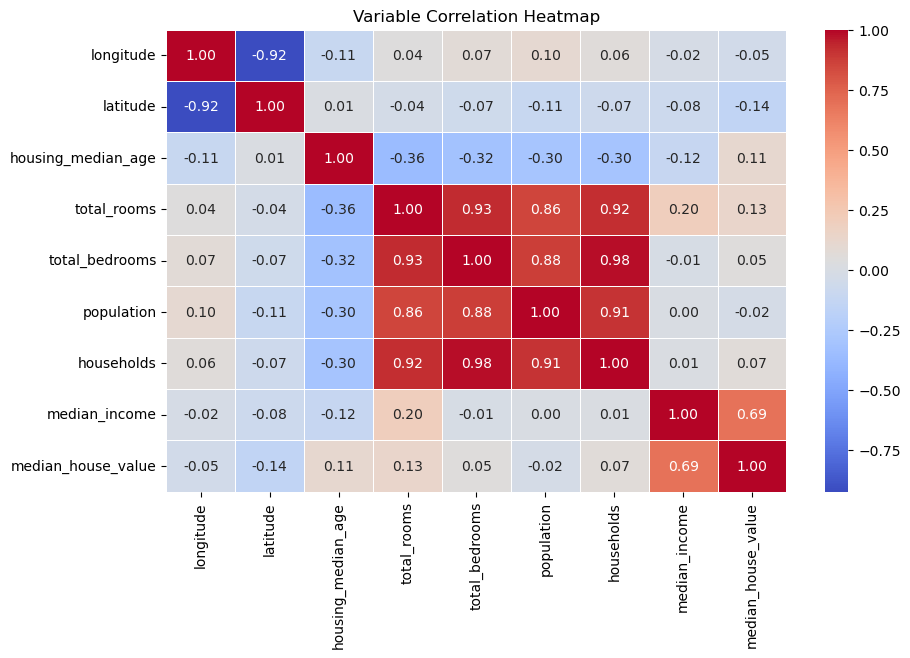

In [9]:
housing = housing.drop(columns=['ocean_proximity'])

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(housing.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Variable Correlation Heatmap')
plt.show()

I dropped the ocean proximity variable just before running this to check for correlations - can't run the code with ocean proximity existing. 

After having thought about how the data is formatted, I have come to the conclusion that undertaking analysis on this raw data would likely not yield meaningful takeaways. This is because when we estimate a house price, we are estimating a SINGLE house price, but this data is looking at geographical space and providing means and medians for the values within those geographical spaces. There is an association there, in that when we have a singular house, it will more likely fall towards those means and medians for it's geographical space, but the sheer number of houses within these coordinates are often vast (as highlighted within population variables, or households). 

So, my new plan/question is - is there a way to transform this data from that conglomeration into something more applicable? I am thinking, for example how we can utilize households and total_rooms/total_bedrooms to get an 'avg_bedrooms_per_house', and 'avg_population_per_house', which should probably more closely correlate with what we are trying to predict, in 'median_house_value'. 

## Preparing data

In [11]:
# This is my first attempt to create a new variable that we can train the model on that should be more applicable to the analysis. The +1e-5 handles 0 values so that they are instead incredibly
# small but also will not cause errors. 

housing["bedrooms_per_household"] = housing["total_bedrooms"] / (housing["households"] + 1e-5)
housing["rooms_per_household"] = housing["total_rooms"] / (housing["households"] + 1e-5)

In [12]:
print(housing[["bedrooms_per_household", "rooms_per_household"]].describe())


       bedrooms_per_household  rooms_per_household
count            20433.000000         20640.000000
mean                 1.097062             5.428999
std                  0.476104             2.474172
min                  0.333333             0.846153
25%                  1.006029             4.440716
50%                  1.048889             5.229129
75%                  1.099631             6.052381
max                 34.066644           141.908962


Output is interesting - you would think that at the 75% that there would be more than 1.1 bedrooms within a household, but then this is also really close to the mean value. We can also calculate the number of people per household, which may be a better indicator than this bedrooms_per_household if the variable is not helpful. 

In [13]:
print(housing[["bedrooms_per_household", "rooms_per_household"]].head())

   bedrooms_per_household  rooms_per_household
0                1.023809             6.984126
1                0.971880             6.238137
2                1.073446             8.288135
3                1.073059             5.817351
4                1.081081             6.281853


In [14]:
# Making a people per household approximation too - may yield better results in the model than bedrooms_per_household.

housing["people_per_household"] = housing["population"] / (housing["households"] + 1e-5)

In [15]:
print(housing[["people_per_household"]].describe())

       people_per_household
count          20640.000000
mean               3.070655
std               10.386034
min                0.692308
25%                2.429741
50%                2.818116
75%                3.282261
max             1243.331261


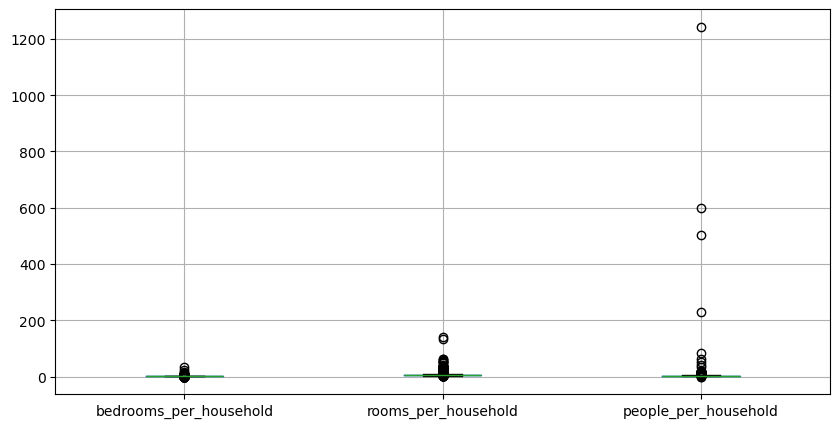

In [16]:
housing[["bedrooms_per_household", "rooms_per_household", "people_per_household"]].boxplot(figsize=(10,5))
plt.show()

Here we can see that there are a few outliers on the people_per_household variable that we made - namely 3 observations where the area has between 400 and over 1200 people per household, which sounds wholly incorrect. 

The best way we should probably handle these is to remove them, and also removing probably the observation with over 200. The logic here is that there realistically shouldn't really be any cases where the amount of people per household should ever exceed the amount of rooms per household, but as we are working with means here, it would technically possibly exist. It just strengthens the data I believe to take this step.

In [17]:
threshold = 200

housing = housing[housing["people_per_household"] <= threshold]

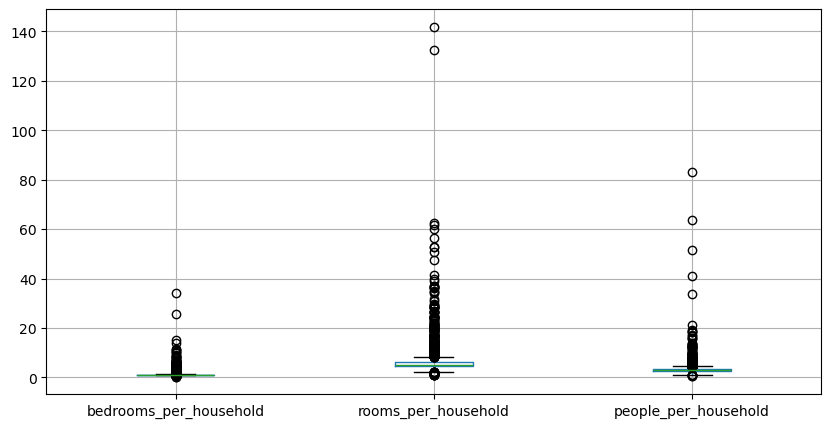

In [18]:
housing[["bedrooms_per_household", "rooms_per_household", "people_per_household"]].boxplot(figsize=(10,5))
plt.show()

In [19]:
print(housing[["people_per_household"]].describe())

       people_per_household
count          20636.000000
mean               2.946435
std                1.221911
min                0.692308
25%                2.429528
50%                2.817937
75%                3.281917
max               83.171421


This lowered the mean by a fairly significant amount (approximately 0.13) which may improve the strength of the model later on. 

So now, we have three variables that we can add to the model. Maybe we do a quick correlation table to just see if there is likely any correlations between these variables and our price outcome. 

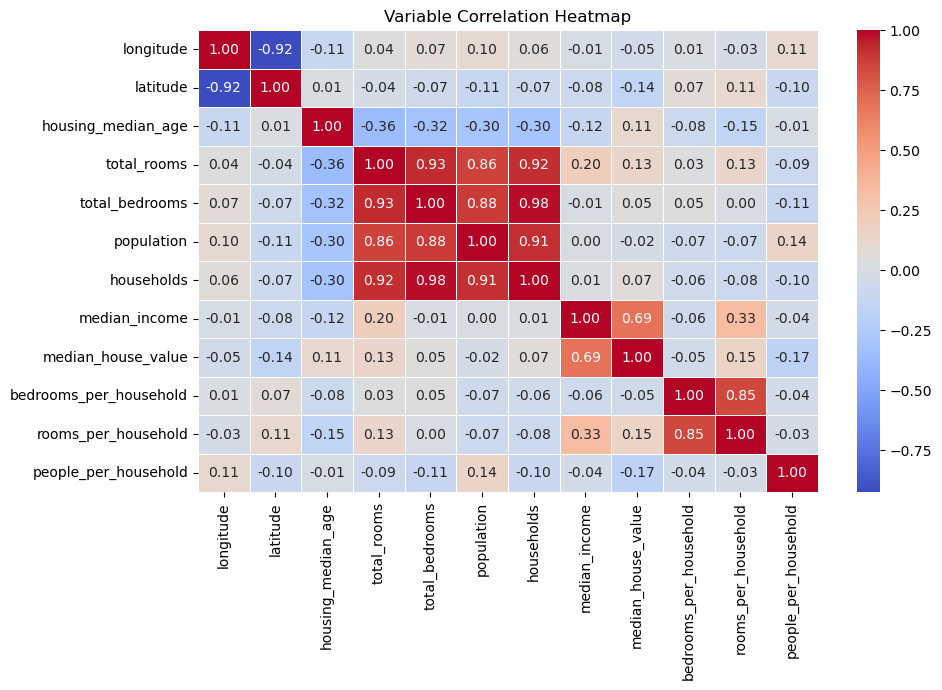

In [20]:
plt.figure(figsize=(10, 6))
sns.heatmap(housing.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Variable Correlation Heatmap')
plt.show()

So from here, we can see the additional variables we have created, but this seems like a bit much for what is being asked in the assignment. The best approach is probably to follow the steps and run our models with just the desired variables from the base set that we had. 

In [21]:
# Using median house value as y in model.
y = housing["median_house_value"]

# Specifying which variables we want to include/exclude in our model as predictors/independents.
X = housing.drop(columns=["median_house_value", "longitude", "latitude", "households", "population", "bedrooms_per_household", "rooms_per_household", "people_per_household"])

# First split for training and a temporary set that will be split again for validation and test (80/20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
# Second split of temp into validation and test set (50/50 of temp, 10/10 of total dataset)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (16508, 4), (16508,)
Validation set: (2064, 4), (2064,)
Test set: (2064, 4), (2064,)


In [22]:
print(X_train.isnull().sum())

housing_median_age      0
total_rooms             0
total_bedrooms        139
median_income           0
dtype: int64


In [29]:
print("Missing values (pre-imputation):")
print(X_train.isnull().sum())

imputer = SimpleImputer(strategy="median")

# Fit the SimpleImputer ONLY on the training set, and then apply that separately to the other sets so as to avoid the test/validation sets from influencing the training set. 
imputer.fit(X_train)

X_train_imputed = imputer.transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_val = pd.DataFrame(X_val_imputed, columns=X_val.columns)
X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns)

Missing values (pre-imputation):
housing_median_age      0
total_rooms             0
total_bedrooms        139
median_income           0
dtype: int64


In [30]:
print("Missing values (post-imputation):")
print(X_train.isnull().sum())

Missing values (post-imputation):
housing_median_age    0
total_rooms           0
total_bedrooms        0
median_income         0
dtype: int64


Excluded variables have been noted as longitude/latitude, as these are geographical coordinates, they have no real place in a regression analysis - it can't be interpreted in any meaningful way. Households simply refers to the amount of households in the geographically defined area, which may be in some way valuable, but I thought I would start by making my model small and testing if adding these variables strengthens the model. The same application for population - I don't see it as a direct indicator of property value.

## Evaluation

In [32]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

y_val_pred = linear_reg_model.predict(X_val)

linear_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print(f"RMSE for Linear Regression: {linear_rmse}")

RMSE for Linear Regression: 79241.22988563462


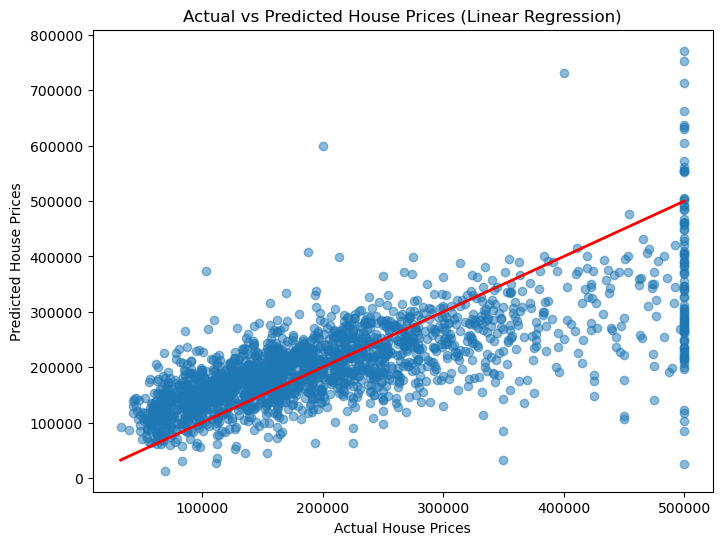

In [ ]:
y_val_pred = linear_reg_model.predict(X_val)

# Plotting the predicted vs actual values.
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linewidth=2)
plt.xlabel('Actual House Prices')
plt.ylabel('Predicted House Prices')
plt.title('Actual vs Predicted House Prices (Linear Regression)')
plt.show()

After a visualization, we can see that this artificial cut-off at 500001 is problematic. It isn't a great model, overall. 

In [34]:
# I was thinking I wanted to see if the relationship improved if we refined the model to only use 'real' median values, not values that appear to be 'above 500001'. 

housing_filtered = housing[housing["median_house_value"] <= 500000]


X = housing_filtered.drop(columns=["median_house_value", "longitude", "latitude", "households", "population", "bedrooms_per_household", "rooms_per_household", "people_per_household"])
y = housing_filtered["median_house_value"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (15736, 4), (15736,)
Validation set: (1967, 4), (1967,)
Test set: (1968, 4), (1968,)


In [36]:
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)


X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_val = pd.DataFrame(X_val_imputed, columns=X_val.columns)
X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns)

print(X_train.isnull().sum())

housing_median_age    0
total_rooms           0
total_bedrooms        0
median_income         0
dtype: int64


Re-running the imputer as I got fresh errors after my previous split.

In [37]:
lr = LinearRegression()

lr.fit(X_train, y_train)

y_train_pred_lr = lr.predict(X_train)
y_val_pred_lr = lr.predict(X_val)

rmse_train_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
rmse_val_lr = np.sqrt(mean_squared_error(y_val, y_val_pred_lr))

print(f"Linear Regression RMSE (Train): {rmse_train_lr}")
print(f"Linear Regression RMSE (Validation): {rmse_val_lr}")

Linear Regression RMSE (Train): 69204.81406468735
Linear Regression RMSE (Validation): 69906.95497258088


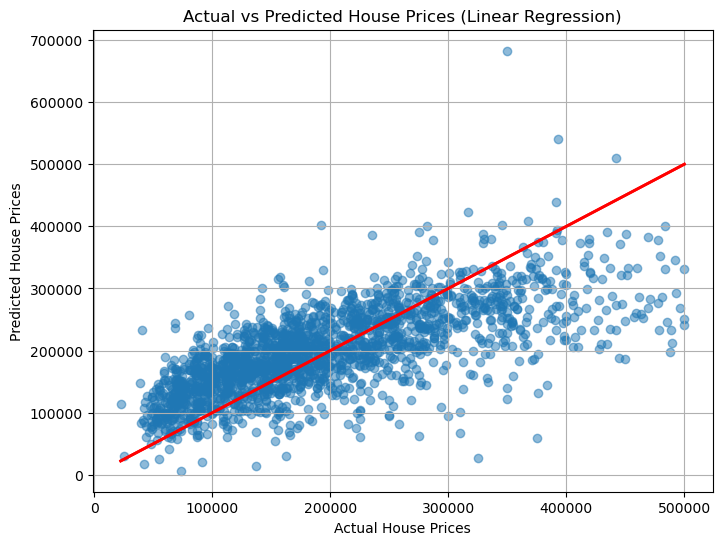

In [40]:
y_val_pred = linear_reg_model.predict(X_val)

# Plotting the predicted vs actual values
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linewidth=2)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linewidth=2)
plt.grid(True)
plt.xlabel('Actual House Prices')
plt.ylabel('Predicted House Prices')
plt.title('Actual vs Predicted House Prices (Linear Regression)')
plt.show()

In [42]:
param_grid = {'alpha': np.logspace(-4, 4, 50)} 

grid_search = GridSearchCV(Lasso(), param_grid, scoring='neg_root_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

best_lasso = grid_search.best_estimator_

y_train_pred_lasso = best_lasso.predict(X_train)
y_val_pred_lasso = best_lasso.predict(X_val)

rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))
rmse_val_lasso = np.sqrt(mean_squared_error(y_val, y_val_pred_lasso))

print(f"Lasso RMSE (Train): {rmse_train_lasso}")
print(f"Lasso RMSE (Validation): {rmse_val_lasso}")
print(f"Linear Regression RMSE (Train): {rmse_train_lr}")
print(f"Linear Regression RMSE (Validation): {rmse_val_lr}")


# Comparing both models
if rmse_val_lr < rmse_val_lasso:
    print("Linear Regression is better on the validation set")
else:
    print("Lasso is better on the validation set")

Lasso RMSE (Train): 69204.81533755209
Lasso RMSE (Validation): 69906.93750883764
Linear Regression RMSE (Train): 69204.81406468735
Linear Regression RMSE (Validation): 69906.95497258088
Lasso is better on the validation set


In [44]:
print(best_lasso.coef_)

[ 1.75214230e+03 -2.41581926e+01  1.47172640e+02  4.94965662e+04]


## Conclusions

We can see that the model is not fantastic at predicting house prices. The Lasso model is better, but both models perform very similarly overall. I believe that there is merit to this however providing we can either gather better data or adequately transform the data into variables that are more easily utilized within the model. 

One key issue is the scaling effect. If we are trying to predict the price of a house, the variables that we are using to predict the price are often on a median scale of the houses in that area, not the house itself. 